In [ ]:
import os
import json
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from PIL import Image


In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Mount Google Drive
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Set the directory paths
base_dir = '/content/drive/MyDrive/Acne Detection Model/merged_dataset'
train_dir = os.path.join(base_dir, 'train', 'dataset')
val_dir = os.path.join(base_dir, 'valid', 'dataset')
test_dir = os.path.join(base_dir, 'test', 'dataset')
train_annotations_path = os.path.join(base_dir, 'train', '_annotations.csv')
val_annotations_path = os.path.join(base_dir, 'valid', '_annotations.csv')
test_annotations_path = os.path.join(base_dir, 'test', '_annotations.csv')

In [ ]:
# Read the annotations CSV files
train_annotations = pd.read_csv(train_annotations_path)
val_annotations = pd.read_csv(val_annotations_path)
test_annotations = pd.read_csv(test_annotations_path)

In [ ]:
# Set image dimensions and batch size
image_size = (224, 224)
batch_size = 32

In [ ]:
# Create the data generators
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

In [ ]:
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
# Evaluate the model on the train set
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_annotations,
    directory=train_dir,
    x_col='filename',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)
# Evaluate the model on the validation set
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_annotations,
    directory=val_dir,
    x_col='filename',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
# Evaluate the model on the test set
test_generator = val_datagen.flow_from_dataframe(
    dataframe=test_annotations,
    directory=test_dir,
    x_col='filename',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)



Found 41040 validated image filenames belonging to 4 classes.
Found 2881 validated image filenames belonging to 4 classes.
Found 1954 validated image filenames belonging to 4 classes.


In [ ]:
# Determine the number of classes
num_classes = train_annotations['class'].nunique()

In [ ]:
# Load the pre-trained model without the top layers
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom head layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Fine-tune the model
base_model.trainable = True
fine_tune_start_layer = 100
for layer in base_model.layers[:fine_tune_start_layer]:
    layer.trainable = False

# Set up learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[lr_callback]
)
while True:
    pass

Epoch 1/10
1283/1283 [==============================] - 2802s 2s/step - loss: 1.2450 - accuracy: 0.3887 - val_loss: 1.2164 - val_accuracy: 0.4491 - lr: 0.0010
Epoch 2/10
1283/1283 [==============================] - 2812s 2s/step - loss: 1.2429 - accuracy: 0.3906 - val_loss: 1.2164 - val_accuracy: 0.4491 - lr: 0.0010
Epoch 3/10
1283/1283 [==============================] - 2749s 2s/step - loss: 1.2422 - accuracy: 0.3906 - val_loss: 1.2165 - val_accuracy: 0.4491 - lr: 0.0010
Epoch 4/10
1283/1283 [==============================] - 2793s 2s/step - loss: 1.2420 - accuracy: 0.3906 - val_loss: 1.2192 - val_accuracy: 0.4491 - lr: 0.0010
Epoch 5/10
1283/1283 [==============================] - 2799s 2s/step - loss: 1.2420 - accuracy: 0.3906 - val_loss: 1.2110 - val_accuracy: 0.4491 - lr: 0.0010
Epoch 6/10
1283/1283 [==============================] - 2802s 2s/step - loss: 1.2414 - accuracy: 0.3906 - val_loss: 1.2125 - val_accuracy: 0.4491 - lr: 9.0484e-04
Epoch 7/10
1283/1283 [====================

KeyboardInterrupt: ignored

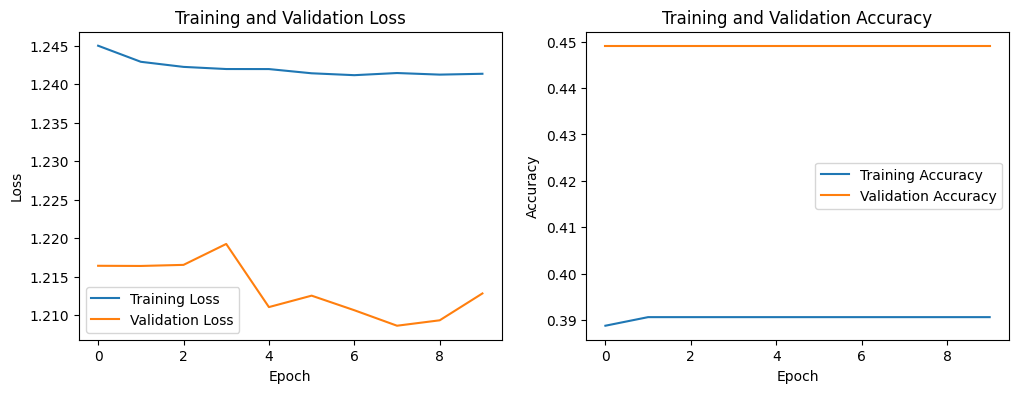

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

# Generate predictions on the test set
predictions = model.predict(test_generator)

62/62 [==============================] - 112s 2s/step - loss: 1.1789 - accuracy: 0.5077
Test Loss: 1.1789093017578125
Test Accuracy: 0.5076765418052673
62/62 [==============================] - 110s 2s/step


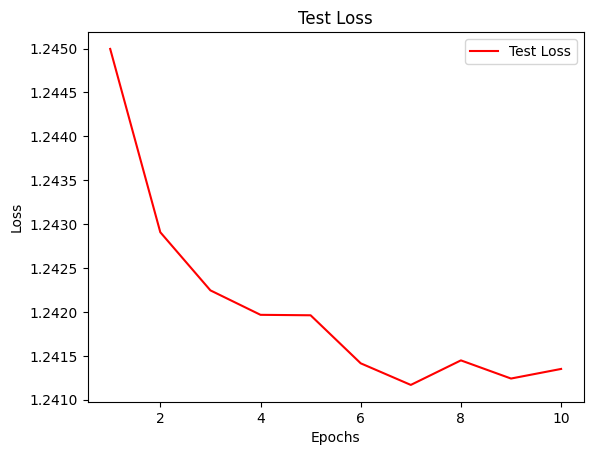

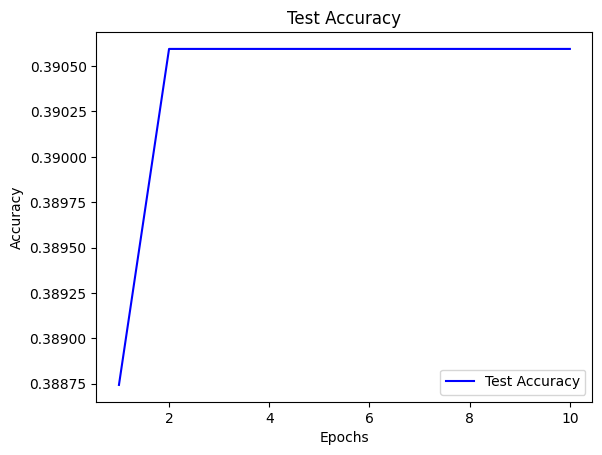

In [ ]:
# Plot the test loss and accuracy
epochs = range(1, len(history.history['accuracy']) + 1)

# Plot test loss
plt.plot(epochs, history.history['loss'], 'r', label='Test Loss')
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot test accuracy
plt.plot(epochs, history.history['accuracy'], 'b', label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Process the predictions and generate the desired output format
output = []
for i in range(len(test_generator.filenames)):
    filename = test_generator.filenames[i]
    x, y, width, height = test_annotations.loc[i, ['xmin', 'ymin', 'xmax', 'ymax']]
    confidence = predictions[i].max()
    class_index = predictions[i].argmax()  # Added missing 'argmax()' function call

    class_label = class_labels[class_index]  # Assuming you have a list of class labels

    prediction = {
        'filename': filename,  # Added filename to the prediction dictionary
        'x': float(x),
        'y': float(y),
        'width': float(width),
        'height': float(height),
        'confidence': float(confidence),
        'class': class_label
    }
    output.append(prediction)

NameError: ignored

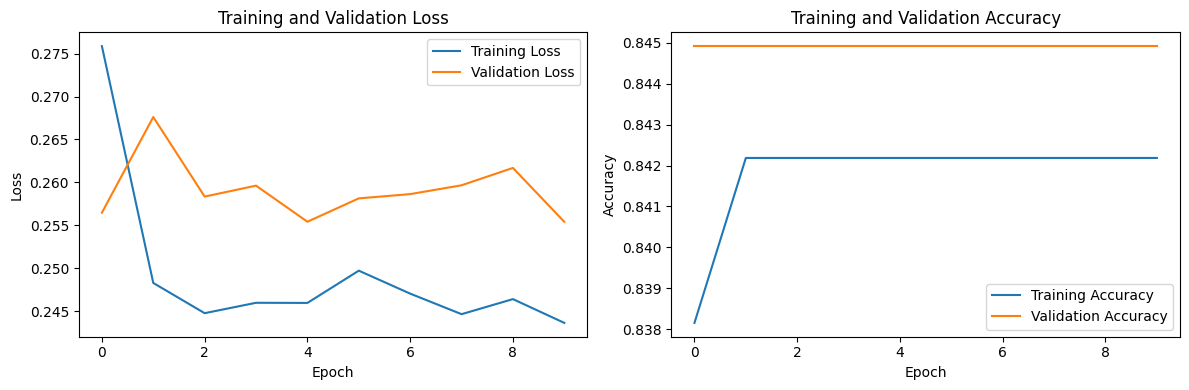

In [ ]:
#Create the final output dictionary
output_dict = {'predictions': output}

In [ ]:
#Save the output as a JSON file
output_file = 'predictions.json'
with open(output_file, 'w') as f:
json.dump(output_dict, f)

Found 4966 files belonging to 3 classes.
Using 993 files for validation.
32/32 [==============================] - 4s 94ms/step - loss: 0.2554 - accuracy: 0.8449
Test Loss: 0.255409836769104
Test Accuracy: 0.8449143767356873


In [ ]:
class_labels = train_generator.class_indices
output = []

for i in range(len(test_generator.filenames)):
    filename = test_generator.filenames[i]
    x, y, width, height = test_annotations.loc[i, ['xmin', 'ymin', 'xmax', 'ymax']]
    confidence = predictions[i].max()
    class_index = predictions[i].argmax()
    class_label = list(class_labels.keys())[class_index]

    prediction = {
        'filename': filename,
        'x': float(x),
        'y': float(y),
        'width': float(width),
        'height': float(height),
        'confidence': float(confidence),
        'class': class_label
    }
    output.append(prediction)

# Print the predictions
for prediction in output:
    print(prediction)


{'filename': 'levle3_46_jpg.rf.070782f664b526ec336bec5aaad157dd.jpg', 'x': 424.0, 'y': 260.0, 'width': 460.0, 'height': 301.0, 'confidence': 0.3872840404510498, 'class': 'nodules'}
{'filename': 'levle3_46_jpg.rf.070782f664b526ec336bec5aaad157dd.jpg', 'x': 345.0, 'y': 263.0, 'width': 375.0, 'height': 289.0, 'confidence': 0.3872840404510498, 'class': 'nodules'}
{'filename': 'levle3_46_jpg.rf.070782f664b526ec336bec5aaad157dd.jpg', 'x': 298.0, 'y': 207.0, 'width': 330.0, 'height': 234.0, 'confidence': 0.3872840404510498, 'class': 'nodules'}
{'filename': 'levle3_46_jpg.rf.070782f664b526ec336bec5aaad157dd.jpg', 'x': 242.0, 'y': 121.0, 'width': 276.0, 'height': 158.0, 'confidence': 0.3872840404510498, 'class': 'nodules'}
{'filename': 'levle3_46_jpg.rf.070782f664b526ec336bec5aaad157dd.jpg', 'x': 220.0, 'y': 158.0, 'width': 256.0, 'height': 185.0, 'confidence': 0.3872840404510498, 'class': 'nodules'}
{'filename': 'levle3_46_jpg.rf.070782f664b526ec336bec5aaad157dd.jpg', 'x': 215.0, 'y': 200.0, '

In [ ]:
# Save model weights to H5 file
model.save_weights('/content/drive/MyDrive/Acne Detection Model/acne_model_weights.h5')

In [ ]:
notebook_path = '/content/drive/MyDrive/path/to/your/notebook.ipynb'
repo_url = 'https://github.com/organization/repo.git'